# Data Loading & Preprocessing

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load preprocessed data
X_train_processed = pd.read_csv('/content/drive/MyDrive/Train_Encoded.csv')
X_test_processed = pd.read_csv('/content/drive/MyDrive/Test_Encoded.csv')

In [5]:
#Convert string to list format
X_train_processed['document_vector'] = X_train_processed['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))
X_test_processed['document_vector'] = X_test_processed['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))

In [6]:
# Separate features and class labels
X_train = X_train_processed['document_vector'].tolist()
X_test = X_test_processed['document_vector'].tolist()
y_train = X_train_processed['hate_speech']
y_test = X_test_processed['hate_speech']

In [7]:
class_distribution = y_train.value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
hate_speech
0    13513
1     4229
Name: count, dtype: int64


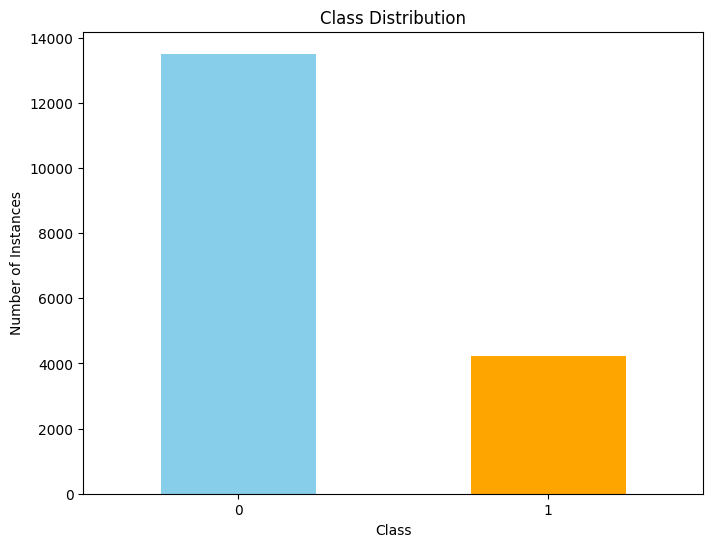

In [8]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
class_distribution = y_train_resampled.value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
hate_speech
0    13513
1    13513
Name: count, dtype: int64


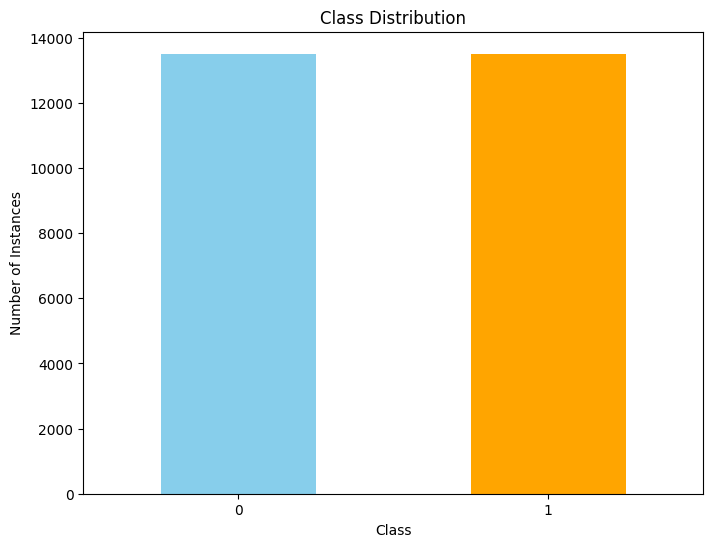

In [11]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

In [12]:
X_train_resampled = np.array(X_train_resampled)

# Check the shape of the resampled dataset
print(X_train_resampled.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_train_resampled.shape)  # Expected shape: (num_samples,)

(27026, 300)
(27026,)


In [13]:
# Reshape train data to match LSTM input shape: (num_samples, 1, embedding_dim)
embedding_dim = X_train_resampled.shape[1]  # Number of features per document vector

X_train_resampled = np.expand_dims(X_train_resampled, axis=1)
print(X_train_resampled.shape) # Should be (num_samples, 1, embedding_dim)

(27026, 1, 300)


In [14]:
X_test = np.array(X_test)

# Check the shape of the resampled dataset
print(X_test.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_test.shape)  # Expected shape: (num_samples,)

(4436, 300)
(4436,)


In [15]:
# Reshape test data to match LSTM input shape: (num_samples, 1, embedding_dim)
X_test = np.expand_dims(X_test, axis=1)
print(X_test.shape)  # Should be (num_samples, 1, embedding_dim)

(4436, 1, 300)


# Model Training

## Single LSTM Layer: 256 Neurons

In [16]:
# Define the LSTM model
model1 = Sequential()

#Define LSTM layer
model1.add(LSTM(256, input_shape=(1, embedding_dim)))

# Add the output layer with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 570625 (2.18 MB)
Trainable params: 570625 (2.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Fit the model using the resampled data
model1.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 9s 7ms/step - loss: 0.5532 - accuracy: 0.7163 - val_loss: 0.7691 - val_accuracy: 0.4410
Epoch 2/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4813 - accuracy: 0.7672 - val_loss: 0.8102 - val_accuracy: 0.4571
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4586 - accuracy: 0.7794 - val_loss: 0.7043 - val_accuracy: 0.5340
Epoch 4/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4435 - accuracy: 0.7892 - val_loss: 0.6362 - val_accuracy: 0.5967
Epoch 5/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4339 - accuracy: 0.7948 - val_loss: 0.6222 - val_accuracy: 0.6114
Epoch 6/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4258 - accuracy: 0.7997 - val_loss: 0.7078 - val_accuracy: 0.5636
Epoch 7/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4182 - accuracy: 0.8053 - val_loss: 0.7348 - val_accuracy: 0.5450
Epoch 

In [18]:
# Predict on the test set
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 3ms/step


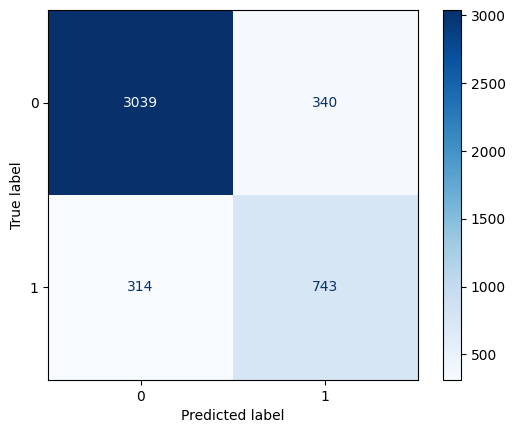

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8526
Precision: 0.6861
Recall: 0.7029
F1 Score: 0.6944


## Single LSTM Layer: 128 Neurons

In [21]:
# Define the LSTM model
model2 = Sequential()

#Define LSTM layer
model2.add(LSTM(128, input_shape=(1, embedding_dim)))

# Add the output layer with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219777 (858.50 KB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Fit the model using the resampled data
model2.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 5s 6ms/step - loss: 0.5623 - accuracy: 0.7056 - val_loss: 0.7712 - val_accuracy: 0.4306
Epoch 2/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4873 - accuracy: 0.7640 - val_loss: 0.6957 - val_accuracy: 0.5126
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4628 - accuracy: 0.7779 - val_loss: 0.7157 - val_accuracy: 0.5266
Epoch 4/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4479 - accuracy: 0.7852 - val_loss: 0.6249 - val_accuracy: 0.5954
Epoch 5/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4388 - accuracy: 0.7920 - val_loss: 0.6350 - val_accuracy: 0.6028
Epoch 6/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4311 - accuracy: 0.7976 - val_loss: 0.6667 - val_accuracy: 0.5816
Epoch 7/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4247 - accuracy: 0.8004 - val_loss: 0.7172 - val_accuracy: 0.5564
Epoch 

In [23]:
# Predict on the test set
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


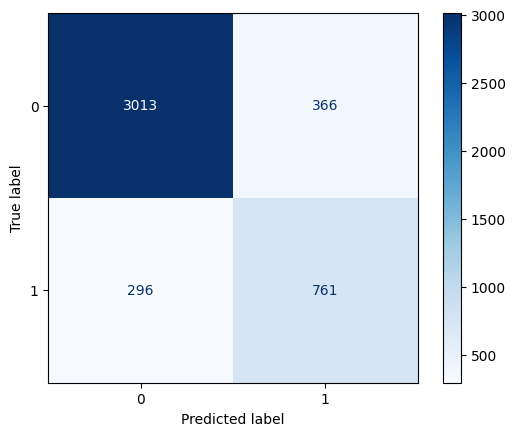

In [24]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8508
Precision: 0.6752
Recall: 0.7200
F1 Score: 0.6969


## Single LSTM Layer: 64 Neurons

In [26]:
# Define the LSTM model
model3 = Sequential()

#Define LSTM layer
model3.add(LSTM(64, input_shape=(1, embedding_dim)))

# Add the output layer with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93505 (365.25 KB)
Trainable params: 93505 (365.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Fit the model using the resampled data
model3.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 4s 6ms/step - loss: 0.5778 - accuracy: 0.6932 - val_loss: 0.6992 - val_accuracy: 0.4615
Epoch 2/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4966 - accuracy: 0.7563 - val_loss: 0.6943 - val_accuracy: 0.5009
Epoch 3/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4704 - accuracy: 0.7717 - val_loss: 0.6989 - val_accuracy: 0.5229
Epoch 4/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4552 - accuracy: 0.7804 - val_loss: 0.6773 - val_accuracy: 0.5540
Epoch 5/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4441 - accuracy: 0.7893 - val_loss: 0.6561 - val_accuracy: 0.5764
Epoch 6/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4358 - accuracy: 0.7942 - val_loss: 0.6409 - val_accuracy: 0.5966
Epoch 7/20
338/338 [==============================] - 2s 5ms/step - loss: 0.4303 - accuracy: 0.7989 - val_loss: 0.7064 - val_accuracy: 0.5616
Epoch 

In [28]:
# Predict on the test set
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


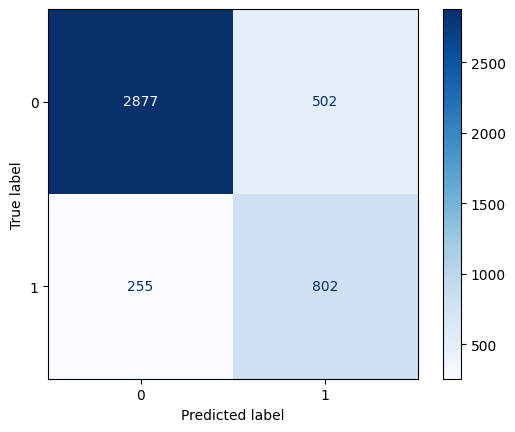

In [29]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8294
Precision: 0.6150
Recall: 0.7588
F1 Score: 0.6794


## Two LSTM Layers: 256 and 128 Neurons

In [31]:
# Define the LSTM model
model4 = Sequential()

#Define LSTM layer
model4.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model4.add(LSTM(128, input_shape=(1, embedding_dim)))

# Add the output layer with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 256)            570368    
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 767617 (2.93 MB)
Trainable params: 767617 (2.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# Fit the model using the resampled data
model4.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 6s 8ms/step - loss: 0.5244 - accuracy: 0.7347 - val_loss: 0.7628 - val_accuracy: 0.5259
Epoch 2/20
338/338 [==============================] - 3s 8ms/step - loss: 0.4527 - accuracy: 0.7809 - val_loss: 0.6500 - val_accuracy: 0.6260
Epoch 3/20
338/338 [==============================] - 3s 9ms/step - loss: 0.4333 - accuracy: 0.7921 - val_loss: 0.5940 - val_accuracy: 0.6680
Epoch 4/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4175 - accuracy: 0.8032 - val_loss: 0.6617 - val_accuracy: 0.6337
Epoch 5/20
338/338 [==============================] - 2s 6ms/step - loss: 0.4050 - accuracy: 0.8109 - val_loss: 0.4440 - val_accuracy: 0.8032
Epoch 6/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3898 - accuracy: 0.8208 - val_loss: 0.4526 - val_accuracy: 0.7919
Epoch 7/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3783 - accuracy: 0.8285 - val_loss: 0.5674 - val_accuracy: 0.7100
Epoch 

In [33]:
# Predict on the test set
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 2s 3ms/step


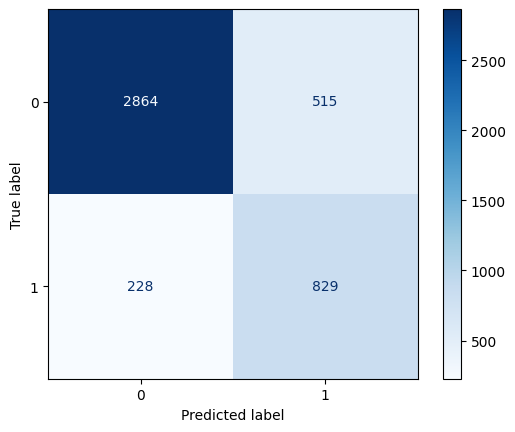

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [35]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8325
Precision: 0.6168
Recall: 0.7843
F1 Score: 0.6905


## Add Dense Layer: 256 Neurons

In [36]:
# Define the LSTM model
model7 = Sequential()

#Define LSTM layer
model7.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model7.add(LSTM(128, input_shape=(1, embedding_dim)))

model7.add(Dense(256, activation='relu'))

# Add the output layer with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 256)            570368    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 800769 (3.05 MB)
Trainable params: 800769 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Fit the model using the resampled data
model7.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 6s 9ms/step - loss: 0.5092 - accuracy: 0.7434 - val_loss: 0.6117 - val_accuracy: 0.6957
Epoch 2/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4503 - accuracy: 0.7801 - val_loss: 0.7105 - val_accuracy: 0.6345
Epoch 3/20
338/338 [==============================] - 3s 9ms/step - loss: 0.4250 - accuracy: 0.7980 - val_loss: 0.5774 - val_accuracy: 0.7022
Epoch 4/20
338/338 [==============================] - 3s 7ms/step - loss: 0.4056 - accuracy: 0.8120 - val_loss: 0.6275 - val_accuracy: 0.6487
Epoch 5/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3909 - accuracy: 0.8227 - val_loss: 0.4403 - val_accuracy: 0.8111
Epoch 6/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3762 - accuracy: 0.8319 - val_loss: 0.6310 - val_accuracy: 0.6755
Epoch 7/20
338/338 [==============================] - 2s 6ms/step - loss: 0.3668 - accuracy: 0.8375 - val_loss: 0.4759 - val_accuracy: 0.7880
Epoch 

In [38]:
# Predict on the test set
y_pred = (model7.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


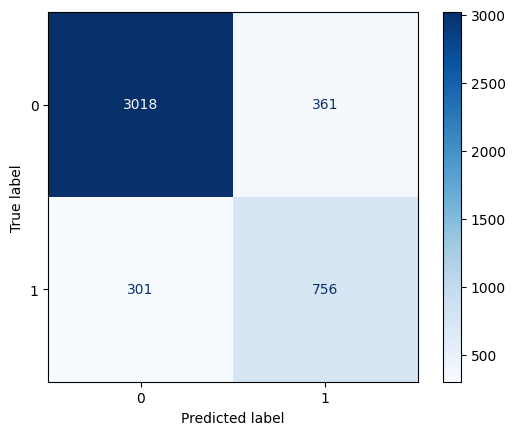

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8508
Precision: 0.6768
Recall: 0.7152
F1 Score: 0.6955


## Dense Layer: 128

In [41]:
# Define the LSTM model
model8 = Sequential()

#Define LSTM layer
model8.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model8.add(LSTM(128, input_shape=(1, embedding_dim)))

model8.add(Dense(128, activation='relu'))

# Add the output layer with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model8.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 256)            570368    
                                                                 
 lstm_8 (LSTM)               (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 784129 (2.99 MB)
Trainable params: 784129 (2.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Fit the model using the resampled data
model8.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 8s 11ms/step - loss: 0.5108 - accuracy: 0.7422 - val_loss: 0.6448 - val_accuracy: 0.6694
Epoch 2/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4461 - accuracy: 0.7848 - val_loss: 0.6142 - val_accuracy: 0.6987
Epoch 3/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4229 - accuracy: 0.8036 - val_loss: 0.6688 - val_accuracy: 0.6524
Epoch 4/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4034 - accuracy: 0.8148 - val_loss: 0.4995 - val_accuracy: 0.7682
Epoch 5/20
338/338 [==============================] - 3s 7ms/step - loss: 0.3907 - accuracy: 0.8215 - val_loss: 0.5003 - val_accuracy: 0.7701
Epoch 6/20
338/338 [==============================] - 3s 9ms/step - loss: 0.3776 - accuracy: 0.8308 - val_loss: 0.5319 - val_accuracy: 0.7423
Epoch 7/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3675 - accuracy: 0.8364 - val_loss: 0.4783 - val_accuracy: 0.7638
Epoch

In [43]:
# Predict on the test set
y_pred = (model8.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


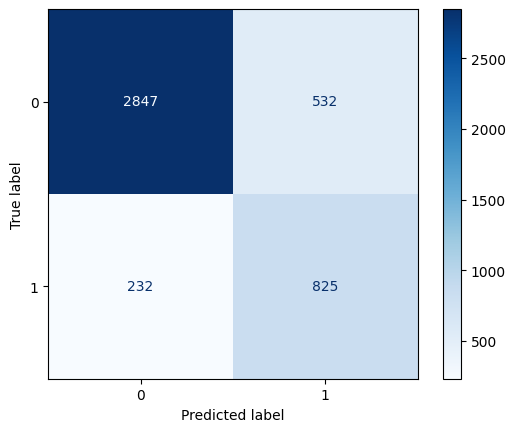

In [44]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8278
Precision: 0.6080
Recall: 0.7805
F1 Score: 0.6835


## Dropout Layer: 0.2

In [66]:
# Define the LSTM model
model9 = Sequential()

#Define LSTM layer
model9.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model9.add(LSTM(128, input_shape=(1, embedding_dim)))

model9.add(Dense(128, activation='relu'))

model9.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model9.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 256)            570368    
                                                                 
 lstm_16 (LSTM)              (None, 128)               197120    
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 800769 (3.05 MB)
Trainable params: 800769 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# Fit the model using the resampled data
model9.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 8s 9ms/step - loss: 0.5099 - accuracy: 0.7411 - val_loss: 0.5872 - val_accuracy: 0.7501
Epoch 2/20
338/338 [==============================] - 3s 9ms/step - loss: 0.4507 - accuracy: 0.7815 - val_loss: 0.6142 - val_accuracy: 0.6852
Epoch 3/20
338/338 [==============================] - 3s 8ms/step - loss: 0.4277 - accuracy: 0.7977 - val_loss: 0.5118 - val_accuracy: 0.7756
Epoch 4/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4064 - accuracy: 0.8132 - val_loss: 0.4003 - val_accuracy: 0.8433
Epoch 5/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3908 - accuracy: 0.8236 - val_loss: 0.4238 - val_accuracy: 0.8280
Epoch 6/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3780 - accuracy: 0.8293 - val_loss: 0.4362 - val_accuracy: 0.8248
Epoch 7/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3687 - accuracy: 0.8361 - val_loss: 0.4932 - val_accuracy: 0.7919
Epoch 

In [48]:
# Predict on the test set
y_pred = (model9.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 3ms/step


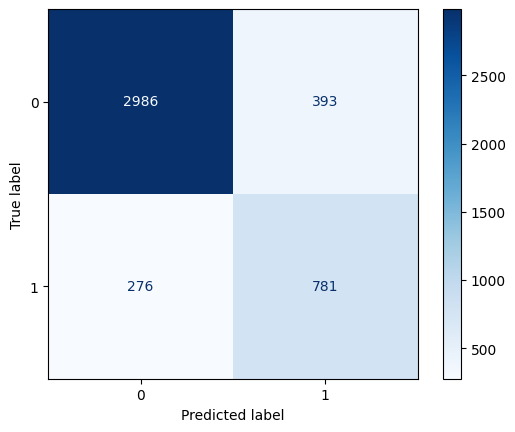

In [49]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8492
Precision: 0.6652
Recall: 0.7389
F1 Score: 0.7001


## Dropout Layer: 0.5

In [51]:
# Define the LSTM model
model10 = Sequential()

#Define LSTM layer
model10.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model10.add(LSTM(128, input_shape=(1, embedding_dim)))

model10.add(Dense(128, activation='relu'))

model10.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model10.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 256)            570368    
                                                                 
 lstm_12 (LSTM)              (None, 128)               197120    
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 784129 (2.99 MB)
Trainable params: 784129 (2.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# Fit the model using the resampled data
model10.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 8s 9ms/step - loss: 0.5183 - accuracy: 0.7425 - val_loss: 0.6333 - val_accuracy: 0.6704
Epoch 2/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4525 - accuracy: 0.7817 - val_loss: 0.5243 - val_accuracy: 0.7606
Epoch 3/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4300 - accuracy: 0.7991 - val_loss: 0.5314 - val_accuracy: 0.7510
Epoch 4/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4103 - accuracy: 0.8116 - val_loss: 0.4411 - val_accuracy: 0.8143
Epoch 5/20
338/338 [==============================] - 3s 9ms/step - loss: 0.3966 - accuracy: 0.8212 - val_loss: 0.3656 - val_accuracy: 0.8751
Epoch 6/20
338/338 [==============================] - 3s 7ms/step - loss: 0.3864 - accuracy: 0.8266 - val_loss: 0.5144 - val_accuracy: 0.7468
Epoch 7/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3800 - accuracy: 0.8305 - val_loss: 0.4919 - val_accuracy: 0.7699
Epoch 

In [53]:
# Predict on the test set
y_pred = (model10.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 3ms/step


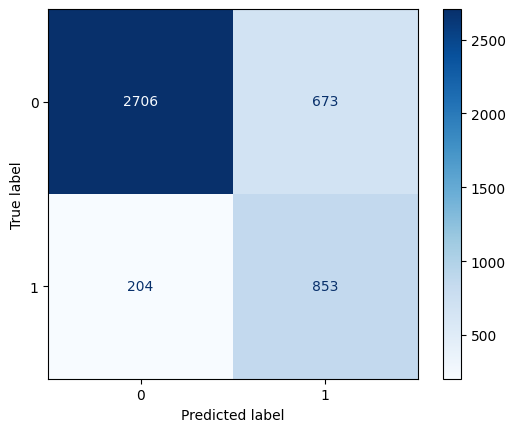

In [54]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [55]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8023
Precision: 0.5590
Recall: 0.8070
F1 Score: 0.6605


# Model Tuning


### Implement early stopping and learning rate reduction techniques, while ensuring that 'y_pred' achieves a balanced precision and recall.


In [76]:
# Define the LSTM model
model= Sequential()

#Define LSTM layer
model.add(LSTM(256, input_shape=(1, embedding_dim), return_sequences=True))

model.add(LSTM(128, input_shape=(1, embedding_dim)))

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1, 256)            570368    
                                                                 
 lstm_20 (LSTM)              (None, 128)               197120    
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 784129 (2.99 MB)
Trainable params: 784129 (2.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Fit the model using the resampled data
model.fit(X_train_resampled, y_train_resampled,
          epochs=20,
          batch_size=64,
          validation_split=0.2)

Epoch 1/20
338/338 [==============================] - 8s 13ms/step - loss: 0.5184 - accuracy: 0.7360 - val_loss: 0.6579 - val_accuracy: 0.6894
Epoch 2/20
338/338 [==============================] - 4s 11ms/step - loss: 0.4540 - accuracy: 0.7763 - val_loss: 0.6714 - val_accuracy: 0.6672
Epoch 3/20
338/338 [==============================] - 2s 7ms/step - loss: 0.4327 - accuracy: 0.7974 - val_loss: 0.4604 - val_accuracy: 0.8187
Epoch 4/20
338/338 [==============================] - 3s 8ms/step - loss: 0.4160 - accuracy: 0.8073 - val_loss: 0.6026 - val_accuracy: 0.6796
Epoch 5/20
338/338 [==============================] - 3s 8ms/step - loss: 0.3976 - accuracy: 0.8193 - val_loss: 0.4348 - val_accuracy: 0.8208
Epoch 6/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3874 - accuracy: 0.8271 - val_loss: 0.3954 - val_accuracy: 0.8670
Epoch 7/20
338/338 [==============================] - 2s 7ms/step - loss: 0.3744 - accuracy: 0.8346 - val_loss: 0.5887 - val_accuracy: 0.7042
Epoc

In [78]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 3ms/step


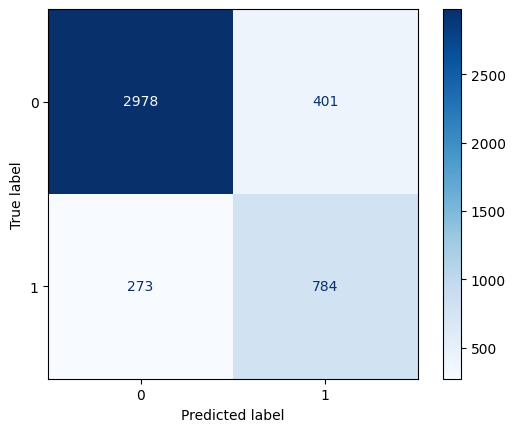

In [79]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [80]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8481
Precision: 0.6616
Recall: 0.7417
F1 Score: 0.6994


In [81]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [82]:
# Fit the model with early stopping and learning rate reduction
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
338/338 [==============================] - 2s 7ms/step - loss: 0.2802 - accuracy: 0.8823 - val_loss: 0.2526 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 2/50
338/338 [==============================] - 2s 7ms/step - loss: 0.2760 - accuracy: 0.8856 - val_loss: 0.2744 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 3/50
338/338 [==============================] - 2s 7ms/step - loss: 0.2698 - accuracy: 0.8883 - val_loss: 0.2570 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 4/50
338/338 [==============================] - 3s 8ms/step - loss: 0.2644 - accuracy: 0.8902 - val_loss: 0.2223 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 5/50
338/338 [==============================] - 3s 9ms/step - loss: 0.2587 - accuracy: 0.8923 - val_loss: 0.2750 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 6/50
338/338 [==============================] - 3s 8ms/step - loss: 0.2550 - accuracy: 0.8949 - val_loss: 0.2257 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 7/50
338/338 [==============================] - 2s 6ms/step - lo

In [83]:
y_pred_prob = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Threshold
best_threshold = thresholds[np.argmax(precision * recall)]
y_pred = (y_pred_prob >= best_threshold).astype(int)

139/139 [==============================] - 0s 3ms/step


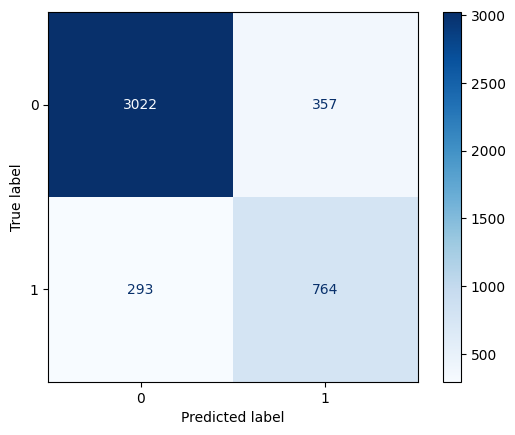

In [84]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [85]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8535
Precision: 0.6815
Recall: 0.7228
F1 Score: 0.7016
